In [106]:
import json
import os
import random
import warnings

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

In [12]:
def flatten_dict(d, parent_key='', sep=':'):
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

def get_dataframes(folder, inclusion_rules=None):
    if inclusion_rules is None:
        inclusion_rules = []
    filenames = [
        filename
        for filename in os.listdir(f"features/{folder}")
        if all(inclusion_rule in filename for inclusion_rule in inclusion_rules)
    ]

    dataframes = []
    for filename in filenames:
        # print(filename)
        with open(f"features/{folder}/{filename}", mode="r", encoding="utf-8") as file:
            features = json.loads(file.read())
            features = flatten_dict(features)
            for feature in features:
                # if feature == "plv:C3_F4_delta":
                #     pass
                if "annotations" not in feature:
                    if max(features[feature]) == min(features[feature]):
                        features[feature] = np.zeros_like(features[feature])
            dataframes.append(pd.DataFrame(features))

    # df = pd.concat(dataframes, ignore_index=True).dropna()
    # for key in df.keys():
    #     if "annotations" in key:
    #         df[key] = df[key].astype(int)

    return dataframes

In [4]:
def merge_data(dfs):
    X = pd.concat(dfs, axis=0, ignore_index=True).dropna()

    y = pd.to_numeric(X["annotations:main"]).values

    annotations_cols = [col for col in X.columns if col.startswith("annotations")]
    X = X.drop(columns=annotations_cols)

    return X, y

In [5]:
def train_val_test_split(dfs, val_n, test_n):
    random.seed(42)
    indices = list(range(len(dfs)))
    random.shuffle(indices)

    test_indices = indices[:test_n]
    val_indices = indices[test_n:val_n + test_n]
    train_indices = indices[val_n + test_n:]

    train_dfs = [dfs[i] for i in train_indices]
    val_dfs = [dfs[i] for i in val_indices]
    test_dfs = [dfs[i] for i in test_indices]

    X_train, y_train = merge_data(train_dfs)
    X_val, y_val = merge_data(val_dfs)
    X_test, y_test = merge_data(test_dfs)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
def translate_feature_names(feature_names):
    TRANSLATION_RULES = [
        ("delta", "дельта"),
        ("theta", "тета"),
        ("alpha", "альфа"),
        ("beta", "бета"),
        ("gamma", "гамма"),
        ("psd:", "[PSD] "),
        ("-", " "),
        ("psd_ratio:", "[отн-е PSD] "),
        ("coh:", "[когер.] "),
        ("plv:", "[PLV] "),
        ("lzc", "[LZC] "),
        ("S:", "[энтроп. К.-С.] "),
        ("Lambda:", "[мера Л.] "),
        (":median", "(бин. по медиане)"),
        (":3:", "(3 инт-ла) "),
        (":4:", "(4 инт-ла) "),
        (":5:", "(5 инт-лов) "),
        (":6:", "(6 инт-лов) "),
        ("spatial4", "(4 инт-ла)"),
        ("spatial6", "(6 инт-лов)"),
        ("spatial10", "(10 инт-лов)"),
        ("spatial14", "(14 инт-лов)"),
        ("spatial20", "(20 инт-лов)"),
        ("spatial24", "(24 инт-ла)"),
        ("temporal3", "(врем., окно 3)"),
        ("temporal4", "(врем., окно 4)"),
        (":", " "),
        ("_", " "),
    ]

    feature_names = np.array(feature_names, dtype="str")
    for rule_from, rule_to in TRANSLATION_RULES:
        feature_names = np.char.replace(feature_names, rule_from, rule_to)

    return feature_names

#

In [492]:
FOLDER = "eegmat"

dfs = get_dataframes(
    FOLDER,
    ["part2"]
    # ["part2", "s3"]
)
df = dfs[1]
df.columns = translate_feature_names(df.columns)
len(dfs)

36

In [364]:
# ISRUC-Sleep
feature_names = [
    "[PSD] F3 альфа",
    "[отн-е PSD] C4 тета/дельта",
    "[когер.] O1 F4 альфа",
    "[PLV] O1 F4 тета",
    "[LZC] (бин. по медиане) F4 дельта",
    "[энтроп. К.-С.] (врем., окно 3) F3 бета",
    "[мера Л.] (врем., окно 3) C3 тета",
]
stage_colors = {
    0: ("silver", "Стадия W"),
    1: ("palegreen", "Стадия N1"),
    2: ("lightseagreen", "Стадия N2"),
    3: ("navy", "Стадия N3"),
    5: ("red", "Стадия REM")
}

In [367]:
# Sleep-EDF
feature_names = [
    "[PSD] Pz Oz гамма",
    "[отн-е PSD] Pz Oz гамма/тета",
    "[когер.] Fpz Cz Pz Oz дельта",
    "[PLV] Fpz Cz Pz Oz дельта",
    "[LZC] (бин. по медиане) Pz Oz гамма",
    "[энтроп. К.-С.] (врем., окно 3) Pz Oz альфа",
    "[мера Л.] (врем., окно 3) Pz Oz гамма",
]
stage_colors = {
    0: ("silver", "Стадия W"),
    1: ("palegreen", "Стадия N1"),
    2: ("lightseagreen", "Стадия N2"),
    3: ("navy", "Стадия N3"),
    5: ("red", "Стадия REM")
}

In [515]:
# EEGMAT
feature_names = [
    "[PSD] O2 тета",
    "[отн-е PSD] O2 гамма/тета",
    "[когер.] O1 F4 тета",
    "[PLV] O1 F4 тета",
    "[LZC] (бин. по медиане) O2 тета",
    "[энтроп. К.-С.] (4 инт-ла) F4 альфа",
    "[мера Л.] (врем., окно 3) F3 тета",
]
stage_colors = {
    0: ("deepskyblue", "Состояние покоя"),
    1: ("orangered", "Процесс решения\nарифметических задач"),
}

In [488]:
# SPIS
feature_names = [
    "[PSD] C3 бета",
    "[отн-е PSD] F3 бета/дельта",
    "[когер.] C4 O2 альфа",
    "[PLV] C4 O2 альфа",
    "[LZC] (бин. по медиане) F4 бета",
    "[энтроп. К.-С.] (4 инт-ла) F4 альфа",
    "[мера Л.] (20 инт-лов) F3 дельта",
]
stage_colors = {
    0: ("orange", "Открытые глаза"),
    1: ("darkviolet", "Закрытые глаза"),
}

In [499]:
boundaries = (0, 8)
boundaries[0] * 30, boundaries[1] * 30

(0, 240)

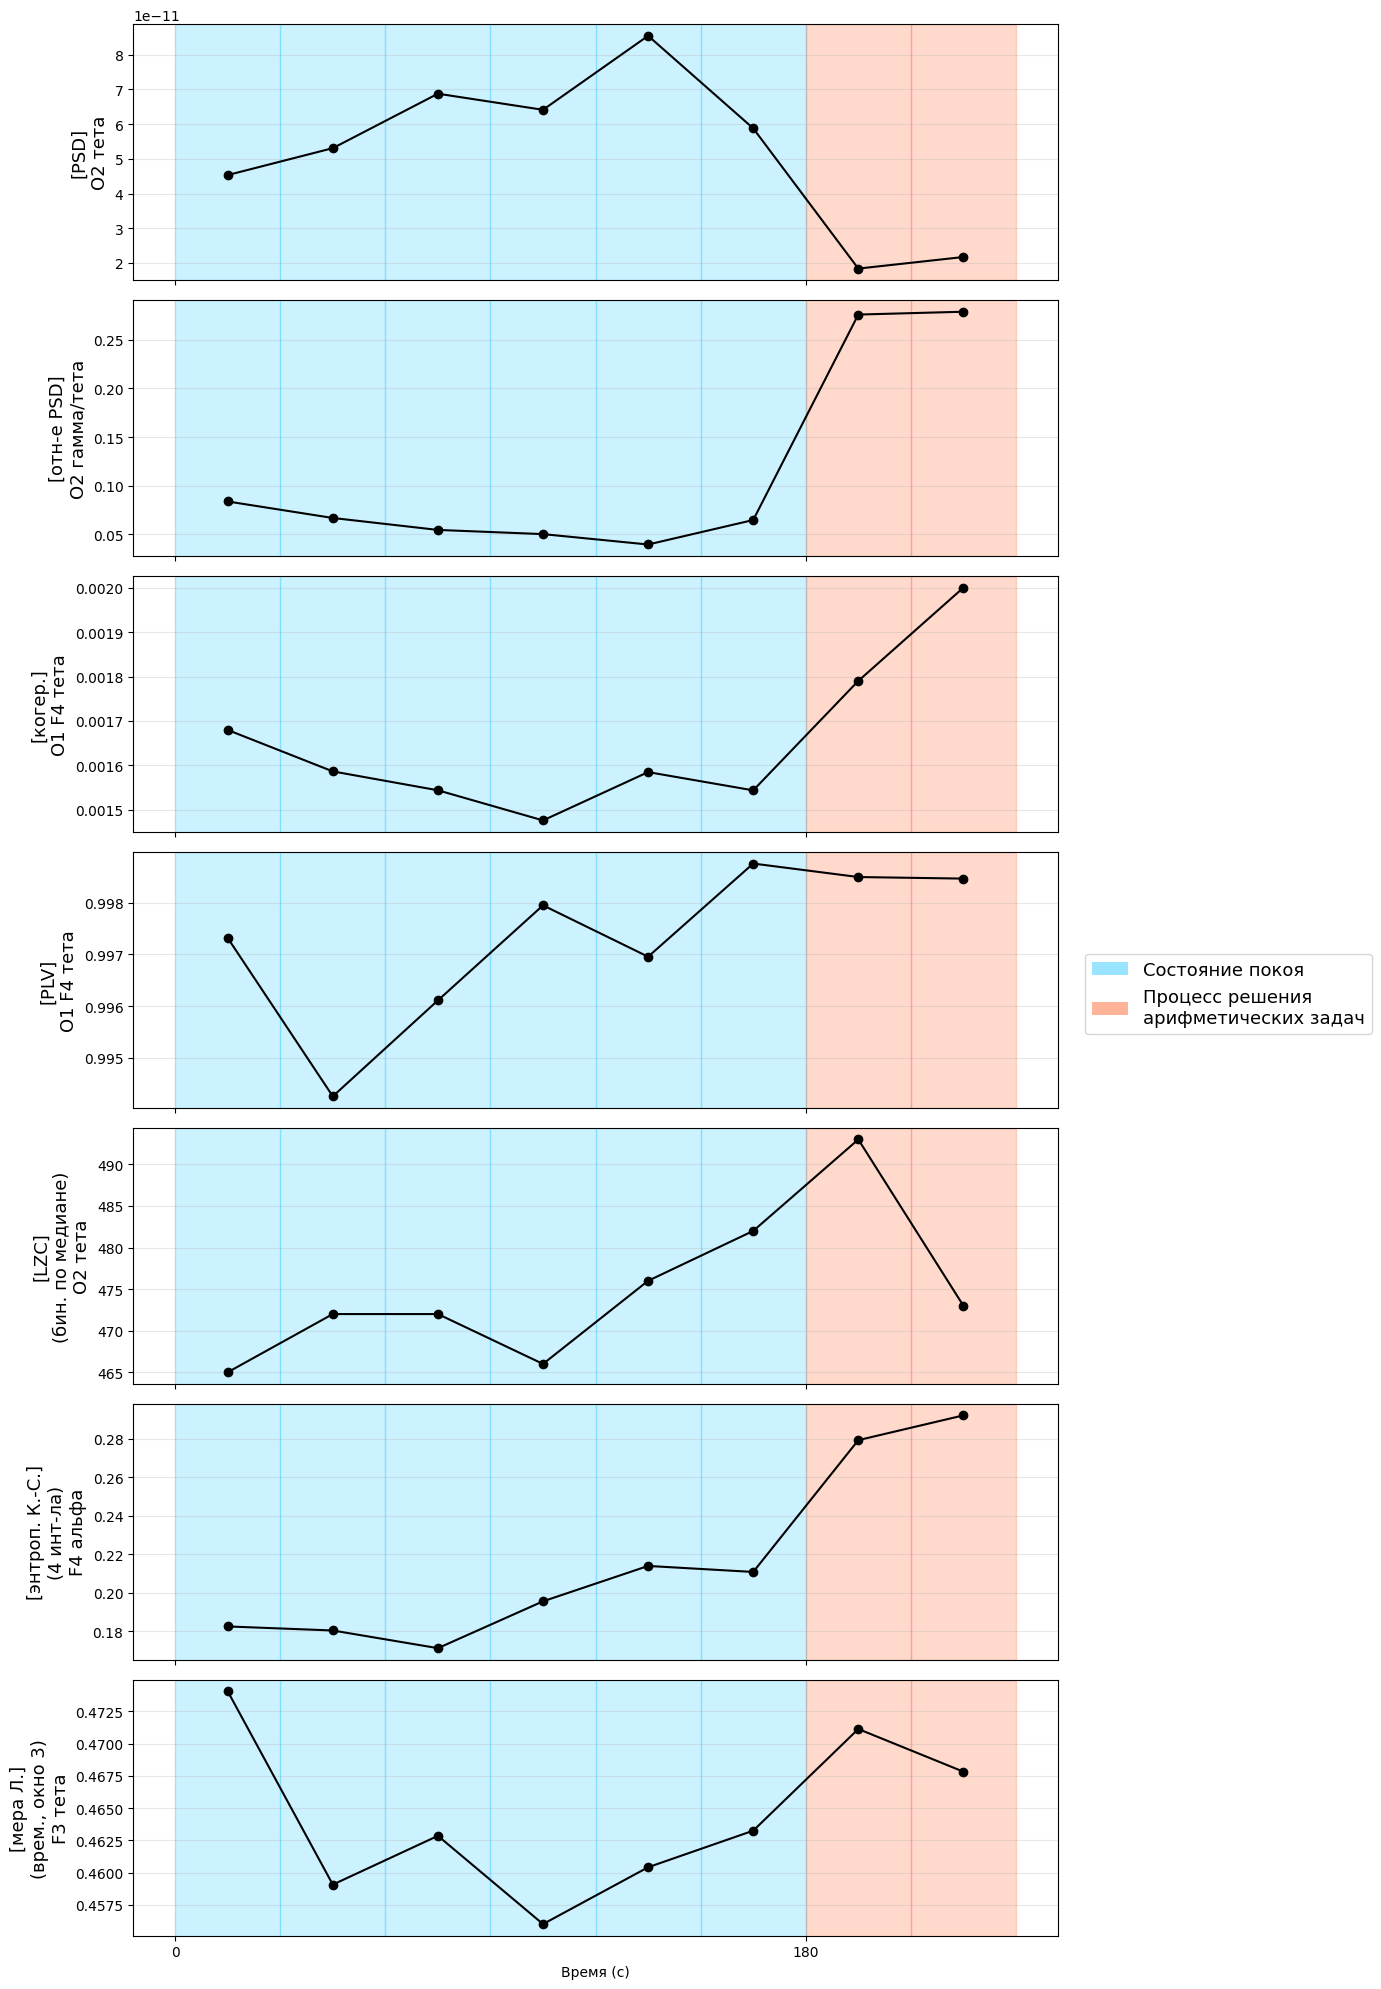

In [519]:
fig, axes = plt.subplots(nrows=len(feature_names), ncols=1, figsize=(14, 20), sharex=True)

n_epochs = boundaries[1] - boundaries[0]
features = df[feature_names]
time_points = np.arange(boundaries[0] * 30, boundaries[1] * 30, 30)
sleep_stages = df["annotations main"][boundaries[0]:boundaries[1]]

mask = ~np.isnan(sleep_stages.astype("float"))
time_points = time_points[mask]
sleep_stages = sleep_stages[mask]

tick_step = 180
xticks = np.arange(boundaries[0] * 30, boundaries[1] * 30, tick_step)

for ax, feature_name in zip(axes, feature_names):
    feature_data = df[feature_name][boundaries[0]:boundaries[1]].to_numpy()

    ax.plot(
        time_points + 15,
        feature_data[mask],
        marker='o',
        linestyle='-',
        color="black"
    )
    ax.set_ylabel(feature_name.replace("] ", "]\n").replace(") ", ")\n"), fontsize=13)
    ax.grid(alpha=0.3)

    for i in sleep_stages.index:
        start = i * 30
        end = start + 30
        stage = sleep_stages[i]
        ax.axvspan(start, end, color=stage_colors[int(stage)][0], alpha=0.2)

axes[-1].set_xticks(xticks)
axes[-1].set_xlabel('Время (с)')

legend_elements = [
    Patch(facecolor=color, alpha=0.4, label=stage_name)
    for _, (color, stage_name) in stage_colors.items()
]

fig.legend(handles=legend_elements, loc="center right", bbox_to_anchor=(0.99, 0.5), fontsize=13)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# EEGMAT
# plt.tight_layout(rect=[0, 0, 0.77, 1])
# SPIS
# plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.savefig(f"plots2/{FOLDER}/a.png")
plt.show()